In [243]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.signal import convolve2d
from scipy.special import comb
import math

In [270]:
def open_image(img_path):
    img = cv2.imread(img_path)
    return img

def get_gray_img_mat(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def expand_image(img, expanded_size, kernel_size=5, ratio=2):
    # Create the expanded image with zeros
    expanded_img = np.zeros(expanded_size)
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / (weights / 4)
    # Upsample the input image
    # Adjust the slicing to match the desired size exactly
    expanded_img[:img.shape[0] * ratio:ratio, :img.shape[1] * ratio:ratio] = img
    # Perform the blur
    expanded_img = np.round(convolve(expanded_img, kernel))
    return expanded_img


def convolve(image, kernel):
    # Perform the convolution using scipy.signal.convolve2d
    result = convolve2d(image, kernel, mode='same', boundary='symm')
    return result


# create a function that returns the gaussian kernel for a given size and the total sum of the kernel
# for example ofr size=5 return kernel = np.array([[1, 4, 6, 4, 1],
# [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]]) and weight = 256
def get_gaussian_kernel(size):
    # Calculate the kernel
    n = math.floor(size)
    kernel = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel[i, j] = comb(n - 1, i) * comb(n - 1, j)

    # Normalize the kernel to make the sum an integer
    kernel_sum = np.sum(kernel)
    kernel_factor = int(np.ceil(kernel_sum))
    kernel = (kernel * kernel_factor / kernel_sum).astype(int)

    return kernel, kernel_factor


def reduce_image(img, reduced_img_size, kernel_size=5, should_blur=True):
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / weights
    # Perform the blur
    if should_blur:
        img = np.round(convolve(img, kernel))

    # Use array slicing and reshaping to select every second element
    reduced_img = img[:reduced_img_size[0] * 2:2, :reduced_img_size[1] * 2:2]

    return reduced_img


def get_reduced_size(img, factor=2):
    return (img.shape[0] // factor, img.shape[1] // factor)


def get_max_level(img):
    return int(np.log2(min(img.shape[0], img.shape[1]))) - 1


# @measure_time
def create_pyramid(img, kernel_size=5):
    pyramid = []
    pyramid.append({'G': img})
    reduced_img = img
    for i in range(1, get_max_level(img)):
        reduced_img_size = get_reduced_size(reduced_img, 2)
        reduced_img = reduce_image(reduced_img, reduced_img_size, kernel_size)
        expanded_image_size = pyramid[i - 1]['G'].shape
        expanded_img = expand_image(reduced_img, expanded_image_size, kernel_size)
        pyramid.append({'G': reduced_img, 'Expanded_G': expanded_img})

    for i in range(len(pyramid) - 1):
        pyramid[i]['L'] = pyramid[i]['G'] - pyramid[i + 1]['Expanded_G']
    pyramid[-1]['L'] = pyramid[-1]['G']
    return pyramid


def get_mask_pyramid(mask):
    mask = np.ceil(mask / 255)
    mask_pyramid = []
    mask_pyramid.append({'G': mask})
    reduced_mask = mask
    for i in range(1, get_max_level(mask)):
        reduced_mask_size = get_reduced_size(reduced_mask, 2)
        reduced_mask = reduce_image(reduced_mask, reduced_mask_size)
        mask_pyramid.append({'G': reduced_mask})
    return mask_pyramid


In [294]:

# img_low_res_path = './assets/lake_low_res.jpg'
# img_high_res_path = './assets/lake_high_res.png'

img_low_res_path = './assets/desert_low_res.jpg'
img_high_res_path = './assets/desert_high_res.png'
######## main ########

    
img_low_res = open_image(img_low_res_path)
img_high_res = open_image(img_high_res_path)
img_high_res_gray = get_gray_img_mat(img_high_res)
img_low_res_gray = get_gray_img_mat(img_low_res)
   
# blue the high resolution image
low_pyramid = create_pyramid(img_low_res_gray)
high_pyramid = create_pyramid(img_high_res_gray)

img_low_res_gray = low_pyramid[2]['G']
img_high_res_gray = high_pyramid[2]['G']
# normalize the image to 8 bit
img_high_res_gray = cv2.normalize(img_high_res_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
img_low_res_gray = cv2.normalize(img_low_res_gray, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_high, des_high = sift.detectAndCompute(img_high_res_gray, None)
kp_low, des_low = sift.detectAndCompute(img_low_res_gray, None)

In [295]:
print('number of keypoints in the high resolution image:', len(kp_high))
print('number of keypoints in the low resolution image:', len(kp_low))

number of keypoints in the high resolution image: 422
number of keypoints in the low resolution image: 844


In [296]:
(des_high.shape)

(422, 128)

In [297]:

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des_high, des_low, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good.append(m)

In [298]:
print('number of good matches:', len(good))

number of good matches: 119


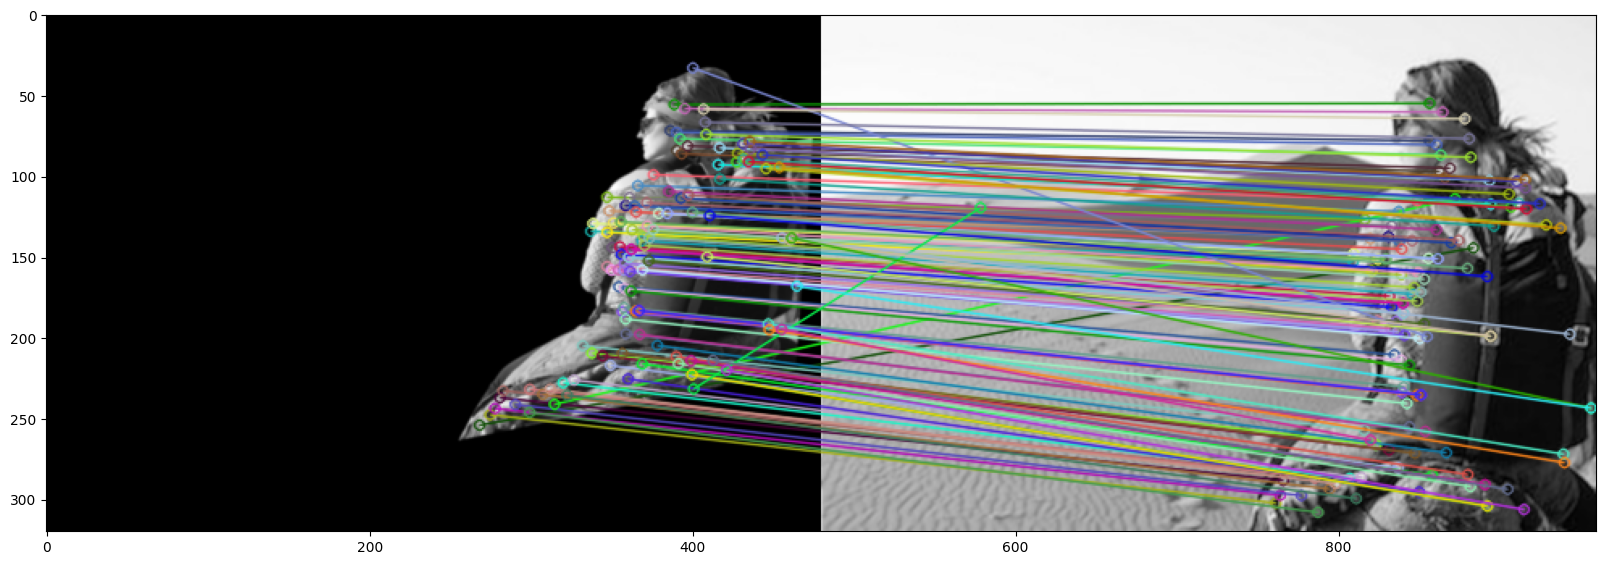

In [288]:
# Draw matches
img3 = cv2.drawMatches(img_high_res_gray, kp_high, img_low_res_gray, kp_low, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
# addapt the size of the plot
plt.gcf().set_size_inches(20, 20)
plt.show()


In [289]:
# Extract keypoints from good matches
kp_high_matched = [kp_high[m.queryIdx] for m in good]
kp_low_matched = [kp_low[m.trainIdx] for m in good]
# covnert keypoints to numpy arrays
src_pts = np.float32([kp.pt for kp in kp_high_matched]).reshape(-1, 1, 2)
dst_pts = np.float32([kp.pt for kp in kp_low_matched]).reshape(-1, 1, 2)

#upsample the points to the original size
src_pts = src_pts * 4
dst_pts = dst_pts * 4

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

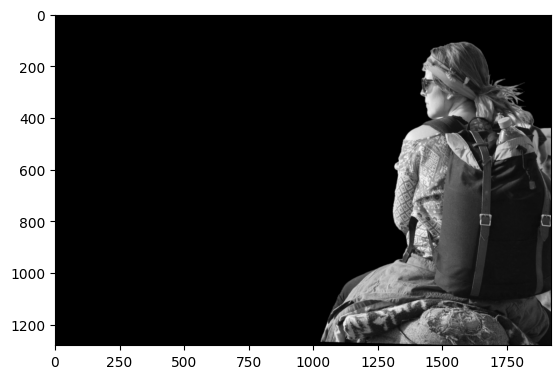

In [290]:
original_low_res_gray = low_pyramid[0]['G']
original_high_res_gray = high_pyramid[0]['G']

# use opneCV to find to apply the homography matrix to the high resolution image and plot the result
h, w = original_low_res_gray.shape
img_warped = cv2.warpPerspective(original_high_res_gray, M, (w, h))
plt.imshow(img_warped, cmap='gray')


In [291]:
M 

array([[ 1.01854403e+00,  1.37945190e-01, -2.09664119e+02],
       [ 2.57726149e-01,  1.36954146e+00, -5.00826984e+02],
       [-4.25202393e-05, -5.05214998e-06,  1.00000000e+00]])

In [292]:
# create colored imag_wraped i.e. for every channel apply the homography matrix and stack into one image
colored_img_warped = np.zeros((h, w, 3), dtype=np.uint8)
for i in range(3):
    colored_img_warped[:, :, i] = cv2.warpPerspective(img_high_res[:, :, i], M, (w, h))
    

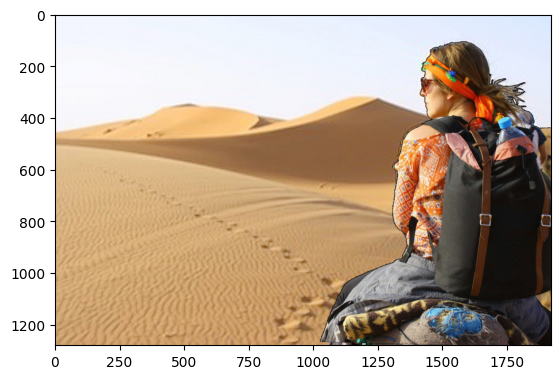

In [293]:
# transformed_img = transform_image(img_high_res, best_H)
# create a mask that is 1 in the area of the transformed image and 0 in the area of the original image
mask = (colored_img_warped != 0).astype(np.uint8)
plt.imshow(mask, cmap='gray')


blended_img = deepcopy(img_low_res)
blended_img[mask == 1] = colored_img_warped[mask == 1]
plt.imshow(cv2.cvtColor(blended_img, cv2.COLOR_BGR2RGB))


In [181]:

# implement the function that returns the transformed image using the homography matrix
def transform_image(img, H):
    # Create the inverse transformation matrix
    H_inv = np.linalg.inv(H)
    # Create the output image
    output_img = np.zeros_like(img)
    # Iterate over the pixels in the output image
    for i in range(output_img.shape[0]):
        for j in range(output_img.shape[1]):
            # Apply the inverse transformation to the pixel coordinates
            p = np.array([i, j, 1])
            p_prime = np.dot(H_inv, p)
            p_prime = (p_prime / p_prime[2])[:2]
            # Check if the transformed pixel is within the bounds of the input image
            if 0 <= p_prime[0] < img.shape[0] and 0 <= p_prime[1] < img.shape[1]:
                # Perform bilinear interpolation
                x0, y0 = int(p_prime[0]), int(p_prime[1])
                x1, y1 = min(x0 + 1, img.shape[0]-1) , min(y0 + 1, img.shape[1]-1)
                dx, dy = p_prime[0] - x0, p_prime[1] - y0
                # Perform the interpolation
                output_img[i, j] = (1 - dx) * (1 - dy) * img[x0, y0] + dx * (1 - dy) * img[x0, y1] + (1 - dx) * dy * img[x1, y0] + dx * dy * img[x1, y1]
    return output_img

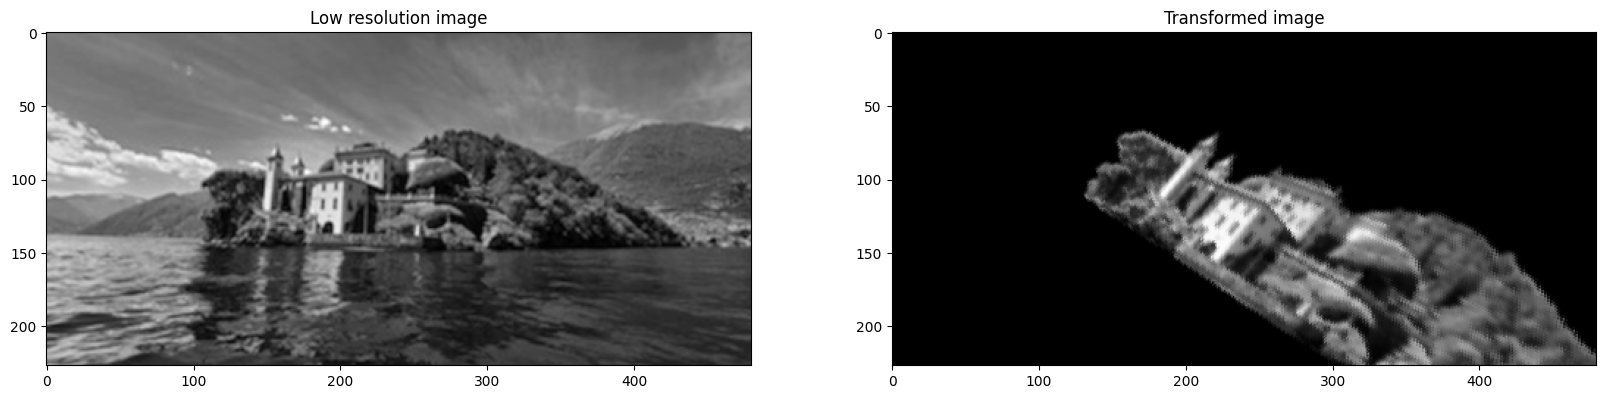

In [216]:
transformed_img = transform_image(img_high_res_gray, M)
#show both transformed and low resolution images next to each other
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_low_res_gray, cmap='gray')
ax[0].set_title('Low resolution image')
ax[1].imshow(transformed_img, cmap='gray')
ax[1].set_title('Transformed image')
# addapt the size of the plot
plt.gcf().set_size_inches(20, 20)